In [40]:
import os

In [41]:
import pickle

In [42]:
random_seed = 42

In [43]:
import random
random.seed(random_seed)
import numpy as np
np.random.seed(random_seed)

import pandas as pd
pd.set_option('display.max_rows', 512)
pd.set_option('display.max_columns', 512)
pd.set_option('display.max_colwidth', -1)

In [44]:
import csv

In [45]:
import matplotlib

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

%matplotlib inline
set_matplotlib_formats('svg')

In [46]:
import torch
import torch.nn as nn
from torch.nn import functional as F

from torch.utils.data import Dataset

In [47]:
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [48]:
from tqdm import tqdm

In [49]:
from sklearn.metrics import classification_report

In [50]:
from scipy import stats

In [51]:
output_collections_list = []
for idx in range(0, 9000+1, 1000):
    with open("saved/score/{}.pkl".format(idx), "rb") as handle:
        output_collections = pickle.load(handle)    
#         print(output_collections[0]['prob'])
        print(len(output_collections))
        
    if idx==0:
        output_collections_list = output_collections
    else:
        output_collections_list += output_collections
len(output_collections_list)        

1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


10000

In [52]:
data = []
for i in output_collections_list:
    data.append([i['index'], 
                 i['influence_prime'], 
                 i['influence'], 
                 i['diff'], i['theta'], 
                 i['sentence1'], i['sentence2'], i['label'], i['prediction'], i['prob'],
                 i['tokens'], i['attributions'],
                ])

df_0 = pd.DataFrame(data, columns=['sample_index', 
                                   'influence_prime', 
                                   'influence', 
                                   'diff', 'theta', 
                                   'sentence1', 'sentence2', 'label', 'prediction', 'prob', 
                                   'tokens', 'attributions'
                                  ])

df_0['theta'] = -df_0['theta']
df_0['attributions'] = -df_0['attributions']

In [53]:
drop_index = df_0[df_0['influence']<=0].index
len(drop_index)

0

In [54]:
df_0.loc[drop_index, 'influence'] = 0.0

In [55]:
df_0['rank'] = df_0['influence'].rank(method='first', ascending=False)

In [56]:
df_0['rank'].head()

0    6484.0
1    6546.0
2    6914.0
3    1372.0
4    7732.0
Name: rank, dtype: float64

In [57]:
mem_list = []
for i in range(0, 100, 10):
    k = int(len(df_0)*i/100)
    print(k)
    mem_list.append(df_0[df_0['rank']==k+1]['influence'].values[0])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [58]:
mem_list

[23.236547470092773,
 4.816572666168213,
 2.2989916801452637,
 0.9182010293006897,
 0.33074086904525757,
 0.11787041276693344,
 0.042152609676122665,
 0.015837857499718666,
 0.0054334960877895355,
 0.0014274033019319177]

In [59]:
def read_report(output_path, order, percentage, seed, epoch, split):
    df = pd.read_csv(os.path.join(output_path, order, percentage, seed, "report/{}_{}.csv".format(epoch-1, split)))
    return df

In [60]:
original = []
for seed in [0, 1, 2, 3, 42]:
    df = read_report('saved', 'mem', str(0), str(seed), 10, 'test')
    original.append(df.loc[2][1])
original

[0.8616389548693587,
 0.8595605700712589,
 0.8634204275534442,
 0.859709026128266,
 0.8617874109263658]

In [61]:
percentage_list = [
    10, 
    20, 
    30, 
    40, 
    50
                  ]

In [62]:
result_dict = {}

for order in [
    'random_0', 
    'random_2', 
    'random', 
    'mem']:
    for percentage in percentage_list:
        result_dict[order+'_'+str(percentage)] = []
        for seed in [0, 1, 2, 3, 42]:
            df = read_report('saved', order, str(percentage), str(seed), 10, 'test')
            result_dict[order+'_'+str(percentage)].append(df.loc[2][1])


In [63]:
result_dict

{'random_0_10': [0.8625296912114014,
  0.8585213776722092,
  0.8608966745843231,
  0.8579275534441805,
  0.8601543942992874],
 'random_0_20': [0.8579275534441805,
  0.8546615201900237,
  0.8576306413301663,
  0.8585213776722092,
  0.8626781472684085],
 'random_0_30': [0.856146080760095,
  0.8540676959619953,
  0.856146080760095,
  0.853770783847981,
  0.8540676959619953],
 'random_0_40': [0.8496140142517815,
  0.8479809976247031,
  0.8484263657957245,
  0.8487232779097387,
  0.8493171021377672],
 'random_0_50': [0.8457541567695962,
  0.8450118764845606,
  0.8460510688836105,
  0.8472387173396675,
  0.8464964370546318],
 'random_2_10': [0.8628266033254157,
  0.8620843230403801,
  0.8594121140142518,
  0.8614904988123515,
  0.8605997624703088],
 'random_2_20': [0.8580760095011877,
  0.8568883610451307,
  0.8594121140142518,
  0.8586698337292161,
  0.8570368171021377],
 'random_2_30': [0.8559976247030879,
  0.8533254156769596,
  0.8565914489311164,
  0.8565914489311164,
  0.85555225653206

In [64]:
(np.mean(result_dict['random_10']) - np.mean(result_dict['mem_10']))*100

0.6175771971496546

In [65]:
(np.mean(result_dict['random_20']) - np.mean(result_dict['mem_20']))*100

0.48396674584323396

In [66]:
(np.mean(result_dict['random_30']) - np.mean(result_dict['mem_30']))*100

0.8254156769596066

In [67]:
(np.mean(result_dict['random_40']) - np.mean(result_dict['mem_40']))*100

0.95605700712591

In [68]:
(np.mean(result_dict['random_50']) - np.mean(result_dict['mem_50']))*100

1.7339667458432295

In [69]:
random_mean_ = []
random_std_ = []

random_mean_.append(np.mean(original)*100)
random_std_.append(np.std(original)*100)

for percentage in percentage_list:
    result = result_dict['random_'+str(percentage)] + result_dict['random_0_'+str(percentage)] + result_dict['random_2_'+str(percentage)]
    random_mean_.append(np.mean(result)*100)
    random_std_.append(np.std(result)*100)

In [70]:
mem_mean = []
mem_std = []

mem_mean.append(np.mean(original)*100)
mem_std.append(np.std(original)*100)

for percentage in percentage_list:
    result = result_dict['mem_'+str(percentage)]
    mem_mean.append(np.mean(result)*100)
    mem_std.append(np.std(result)*100)

In [71]:
mem_mean

[86.12232779097386,
 85.58788598574822,
 85.29394299287411,
 84.83372921615204,
 84.3022565320665,
 83.16508313539194]

In [72]:
mem_std

[0.1440559319561551,
 0.12220377450865019,
 0.15950565342711748,
 0.10564398381625506,
 0.14257965799932118,
 0.15570202615352674]

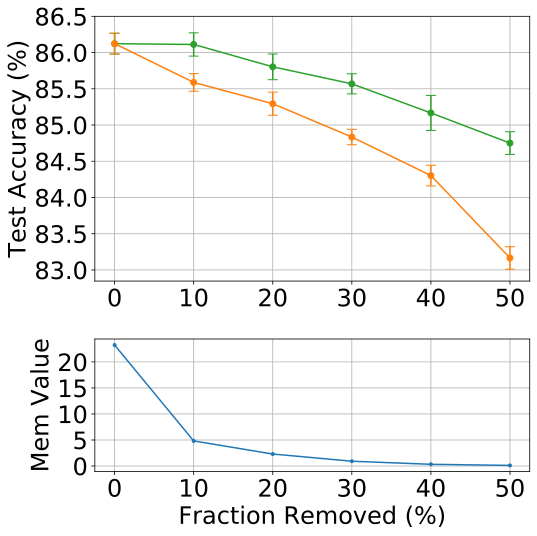

In [73]:
matplotlib.rcParams.update({'font.size': 24})

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), gridspec_kw={'height_ratios': [2, 1]})

# sns.set_style("darkgrid")

x = range(0, 60, 10)

ax0.errorbar(x, random_mean_, 
            yerr=random_std_, 
            linestyle='-', 
            fmt='o', label='random', color='tab:green', capsize=5)
ax0.errorbar(x, mem_mean, 
            yerr=mem_std, 
            linestyle='-', fmt='o', label='memorized', color='tab:orange', capsize=5)

# ax0.legend()

ax0.set_ylabel('Test Accuracy (%)')
ax0.set_xticks(x)

# ax0.set_yticks(np.arange(82.5, 86.00+0.5, 0.5))
ax0.set_yticks(np.arange(np.round(min(random_mean_+mem_mean), 0), np.round(max(random_mean_+mem_mean), 0)+1.0, 0.5))

ax0.grid(True)


ax1.set_xlabel('Fraction Removed (%)')
ax1.set_ylabel('Mem Value')
ax1.set_xticks(x)
ax1.set_yticks(np.arange(0, df_0['influence'].max()+5, 5))



ax1.plot(x, mem_list[0: len(x)], color='tab:blue', marker='.')
ax1.grid(True)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.show()

filename = "saved/vis/Marginal_SNLI.pdf"
os.makedirs(os.path.dirname(filename), exist_ok=True)  

plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)  